In [1]:
import h5py
import tensorflow as tf
import keras
import dask.array as da
import seaborn as sns
#Check if GPU is being used and import other necessary libraries
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
#Again, just import some necessary libraries as part of the preamble in training our dataset
import numpy as np
np.random.seed(1337)  # for reproducibility
from keras.models import Sequential
from keras.initializers import TruncatedNormal, Zeros
from keras.layers import Input, Dense, Dropout, Flatten, MaxPooling2D, Conv2D
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
g = h5py.File("test_pile_5000000.h5", "r")

In [4]:
X_test = da.from_array(g['features'], chunks=(200000, 1, 32,32))
y_test =  da.from_array(g['targets'], chunks=(200000,1))

In [5]:
def dask_generator(X, y, batch_size):
    instances = X.shape[0]
    batches = instances // batch_size
    while True:
        for i in range(batches):
            X_batch = X[i*batch_size:(i+1)*batch_size]
            y_batch = y[i*batch_size:(i+1)*batch_size]
            yield X_batch, y_batch

In [6]:
batch_size = 64
test = dask_generator(X_test, y_test, batch_size)

In [7]:
from DeepSaki.layers import FourierConvolution2D
custom_objects = {"FourierConvolution2D": FourierConvolution2D, "TruncatedNormal": TruncatedNormal,
                 "Zeros": Zeros}

# Load model
model1 = keras.models.load_model("ffcnnmodel.h5", custom_objects=custom_objects)
model2 = keras.models.load_model("conv2dmodel.h5")
model3 = keras.models.load_model("stackmodel.h5", custom_objects=custom_objects)

C:\Users\Sham\anaconda3\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [8]:
model1 = keras.models.Model(inputs=model1.inputs, outputs=model1.outputs, name='ffcnn')
model2 = keras.models.Model(inputs=model2.inputs, outputs=model2.outputs, name='conv2d')
model3 = keras.models.Model(inputs=model3.inputs, outputs=model3.outputs, name='stack')

78125/78125 [==============================] - 647s 8ms/step
Test ROC AUC: 0.93950369879856


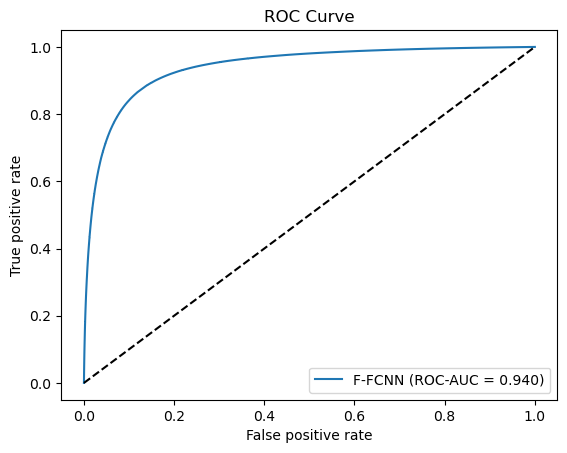

In [9]:
y_predfcnn = model1.predict(test, steps = X_test.shape[0]//64 )
fpr_ffcnn, tpr_ffcnn, _ = roc_curve(y_test, y_predfcnn)
ffcnnroc_auc = auc(fpr_ffcnn, tpr_ffcnn)
print('Test ROC AUC:', ffcnnroc_auc)
plt.plot(fpr_ffcnn, tpr_ffcnn, label='F-FCNN (ROC-AUC = {:.3f})'.format(ffcnnroc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

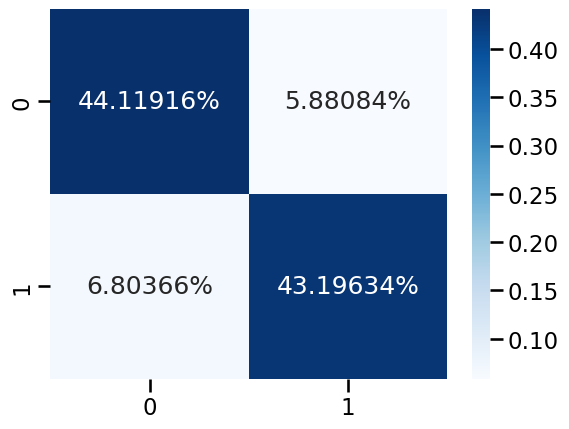

In [10]:
sns.set_context('talk')
ffcnn_cm = confusion_matrix(y_test, np.where(y_predfcnn > 0.5, 1, 0))
ffcnn_ax = sns.heatmap(ffcnn_cm/np.sum(ffcnn_cm), annot=True, fmt='.5%', cmap='Blues')
plt.savefig("ffcnn confusion matrix.png", dpi = 1200)

In [ ]:
###############################################################################################################################

In [ ]:
###############################################################################################################################

In [ ]:
#For traditional Convolution

78125/78125 [==============================] - 218s 3ms/step
Test ROC AUC: 0.9461567996935996


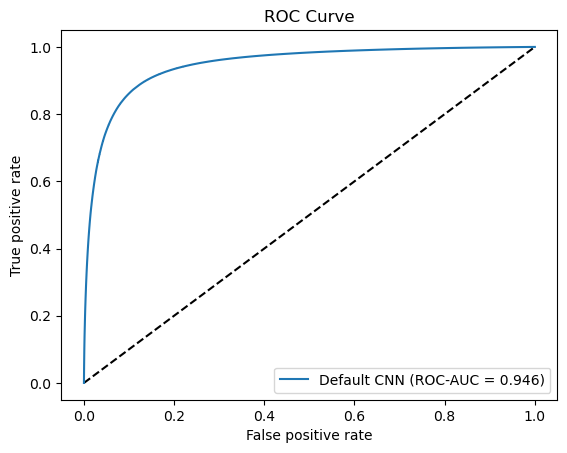

In [9]:
y_predconv2d = model2.predict(test, steps = X_test.shape[0]//64 )
fpr_conv2d, tpr_conv2d, _ = roc_curve(y_test, y_predconv2d)
conv2d_auc = auc(fpr_conv2d, tpr_conv2d)
print('Test ROC AUC:', conv2d_auc)
plt.plot([0, 1], [0, 1], 'k--')
#plt.legend(loc=2, prop={'size': 15})
plt.plot(fpr_conv2d, tpr_conv2d, label='Default CNN (ROC-AUC = {:.3f})'.format(conv2d_auc))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

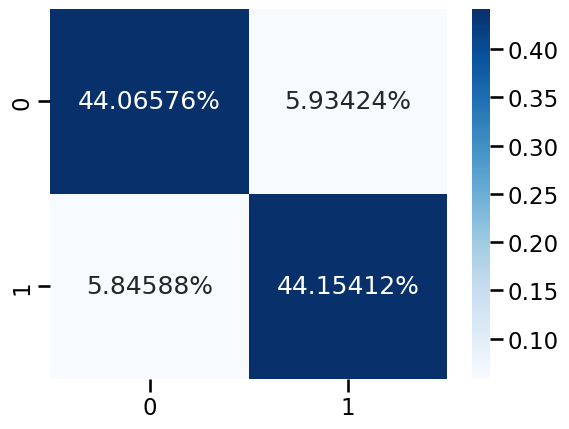

In [10]:
sns.set_context('talk')
cnn_cm = confusion_matrix(y_test, np.where(y_predconv2d>0.5, 1, 0))
cnn_ax = sns.heatmap(cnn_cm/np.sum(cnn_cm), annot=True, fmt='.5%', cmap='Blues')
plt.savefig("traditional_cnn confusion matrix.png", dpi = 1200)

In [ ]:
###############################################################################################################################

In [ ]:
###############################################################################################################################

In [ ]:
#For stacked model

78125/78125 [==============================] - 258s 3ms/step
Test ROC AUC: 0.94563089507792


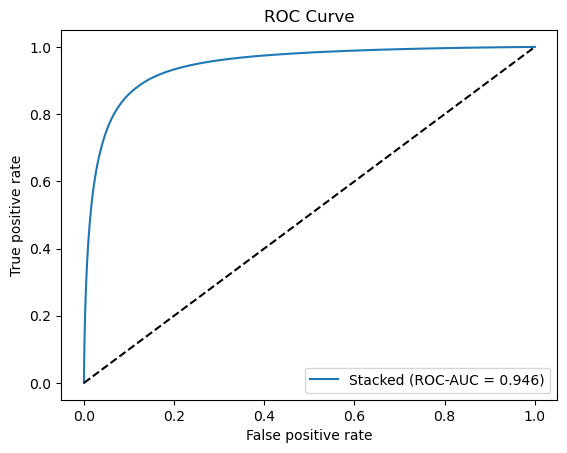

In [9]:
y_predstack = model3.predict(test, steps = X_test.shape[0]//64 )
fpr_stack, tpr_stack, _ = roc_curve(y_test, y_predstack)
stackroc_auc = auc(fpr_stack, tpr_stack)
print('Test ROC AUC:', stackroc_auc)
plt.plot(fpr_stack, tpr_stack, label='Stacked (ROC-AUC = {:.3f})'.format(stackroc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

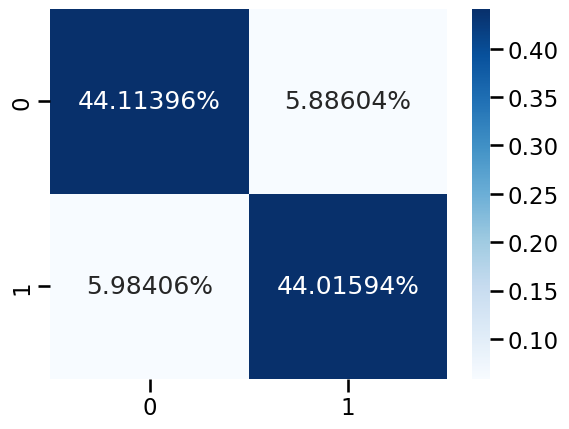

In [10]:
sns.set_context('talk')
stack_cm = confusion_matrix(y_test, np.where(y_predstack > 0.5, 1, 0))
stack_ax = sns.heatmap(stack_cm/np.sum(stack_cm), annot=True, fmt='.5%', cmap='Blues')
plt.savefig("stacked confusion matrix.png", dpi = 1200)

In [ ]:
###############################################################################################################################

In [ ]:
###############################################################################################################################

In [13]:
#High Level Features now

In [10]:
high_train = h5py.File("high level train_pile_10000000.h5", "r")
high_test = h5py.File("high level test_pile_5000000.h5", "r")
#Print a dictionary to see how this dataset looks like
print(list(high_train.keys()))
print(list(high_test.keys()))

['features', 'targets']
['features', 'targets']


In [11]:
Xhigh_train = np.array(high_train["features"])
yhigh_train = np.array(high_train['targets']) 
Xhigh_test = np.array(high_test["features"])
yhigh_test = np.array(high_test['targets'])

In [10]:
# # #Use only first 200,000 instances for demo

# import dask.array as da

# Xhigh_train = da.from_array(high_train["features"], chunks=(1000,6))
# yhigh_train = da.from_array(high_train['targets'], chunks=(1000,1)) 
# Xhigh_test = da.from_array(high_test["features"], chunks=(1000,6))
# yhigh_test = da.from_array(high_test['targets'], chunks=(1000,1))

In [11]:
# train = dask_generator(Xhigh_train, yhigh_train, batch_size)
# test = dask_generator(Xhigh_test, yhigh_test, batch_size)

In [12]:
#So, our high level train pile dataset has 6 features. These are not images.

In [12]:
import pandas as pd

df_features = pd.DataFrame(Xhigh_train)
df_targets = pd.DataFrame(yhigh_train, columns=['output'])

# Concatenate the features and targets dataframes along axis 1
df = pd.concat([df_features, df_targets], axis=1)
pd.DataFrame(df)

,0,1,2,3,4,5,output
0,133.445999,0.350988,0.348813,2.14092,3.206470,0.586944,1.0
1,187.205994,0.517631,0.610113,1.51379,1.758060,0.560413,0.0
2,48.802601,0.212466,0.073543,4.32570,3.090130,0.449218,0.0
3,40.342899,0.111660,0.047073,2.03998,4.256890,0.434656,0.0
4,54.440701,0.148958,0.053297,1.68661,1.908550,0.457619,0.0
...,...,...,...,...,...,...,...
9999995,76.664200,0.150993,0.061574,1.23635,1.339260,0.294474,1.0
9999996,68.491096,0.100347,0.032110,1.07585,1.025710,0.186049,1.0
9999997,74.347000,0.131659,0.033469,1.21415,0.662327,0.297236,1.0
9999998,24.912399,0.102320,0.028468,3.03821,4.490450,0.637800,0.0


In [12]:
#According to the literature, the dataset features are defined as following:
    # 0 - invariant mass
    # 1 - N-subjettiness τ_21 β=1
    #Energy Correlation functions:
        # 2 - C_2 β=1
        # 3 - C_2 β=2
        # 4 - D_2 β=1
        # 5 - D_2 β=2

In [13]:
#We can now use a decision tree for training. Let's use XGBoost.

In [13]:
from xgboost import XGBClassifier
xgb = XGBClassifier(booster = 'gbtree', min_split_loss = 0.1, n_estimators=300, max_depth=15, min_child_weight = 0.025, 
                      learning_rate = 0.07, objective = 'binary:logistic', random_state=42)

In [14]:
features = ['Invariant Mass', r'$\tau_{21}^{\beta=1}$', r'$C_{2}^{\beta=1}$', r'$C_{2}^{\beta=2}$',
           r'$D_{2}^{\beta=1}$', r'$D_{2}^{\beta=2}$']

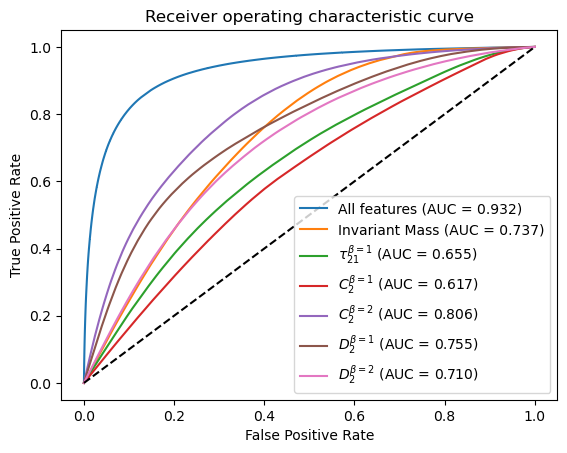

<Figure size 640x480 with 0 Axes>

In [15]:
#Train the model with all the features presented
yhigh_pred = xgb.fit(Xhigh_train, yhigh_train).predict_proba(Xhigh_test)[:, 1]
fpr_all, tpr_all, _ = roc_curve(yhigh_test, yhigh_pred)
roc_auc_all = auc(fpr_all, tpr_all)
# Plot the roc curve
plt.plot(fpr_all, tpr_all, label='All features (AUC = %0.3f)' % roc_auc_all)

# Create a for loop that trains the xgb classifier for each of the feature
for i in range(Xhigh_train.shape[1]):
    
    X_i = Xhigh_train[:, i:i+1] #Take only the ith feature (0,1,2,3,4,5)

    xgb.fit(X_i, yhigh_train) # Train the xgb classifier

    y_pred = xgb.predict_proba(Xhigh_test[:, i:i+1])[:, 1] #Test set evaluation

    # Calculate the ROC curve and AUC score for this feature
    fpr, tpr, _ = roc_curve(yhigh_test, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label='%s (AUC = %0.3f)' % (features[i], roc_auc)) # Plot roc curve for the ith feature


#Plotting
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()
plt.savefig("all graphs2.png", dpi=1200)

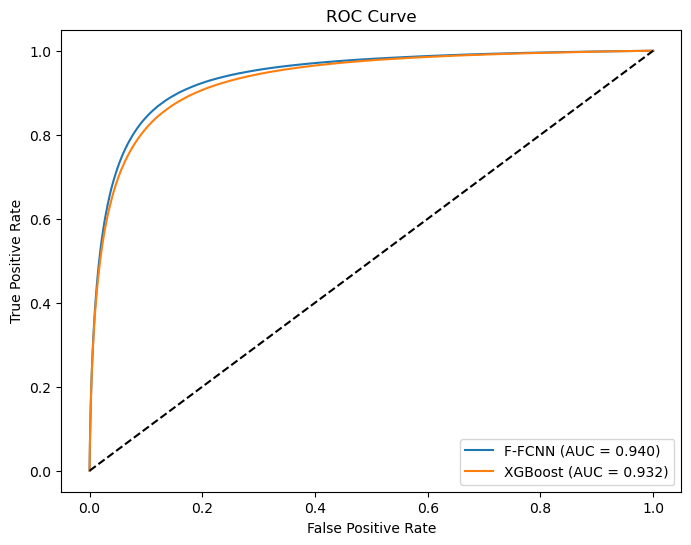

In [17]:
#Plot both roc curve (fcnn and xgboost) in one plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_ffcnn, tpr_ffcnn, label='F-FCNN (AUC = %0.3f)' % ffcnnroc_auc)
plt.plot(fpr_all, tpr_all, label='XGBoost (AUC = %0.3f)' % roc_auc_all)
plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig("fcnn vs xgboost roc.png", dpi=1200)
plt.show()